In [23]:
# Reference sources outside the Learning from Data course:
# https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html
# https://emcee.readthedocs.io/en/stable/tutorials/line/
# for backend: https://emcee.readthedocs.io/en/stable/tutorials/monitor/

import numpy as np
import scipy as scipy
import matplotlib
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
import matplotlib.ticker as ticker
#import h5py
%matplotlib inline
plt.rcParams['figure.figsize'] = (16/2.54,9/2.54)
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif", 
    "font.serif" : ["Computer Modern Roman"]
    })

def set_font_size(axis, tick, legend):
    matplotlib.rc('font',   size=axis)      #2022-06-21: not sure what the difference is, to test later on!
    matplotlib.rc('axes',   titlesize=axis) #2022-06-21: not sure what the difference is, to test later on!
    matplotlib.rc('axes',   labelsize=axis) #2022-06-21: not sure what the difference is, to test later on!
    matplotlib.rc('xtick',  labelsize=tick)
    matplotlib.rc('ytick',  labelsize=tick)
    matplotlib.rc('legend', fontsize=legend)
    print("DONE: set_font_size: (axis, tick, legend): " + str(axis) + ", " + str(tick) + ", " + str(legend))

set_font_size(11,9,9)

#TODO: set font size and all that, see plot-data 

DONE: set_font_size: (axis, tick, legend): 11, 9, 9


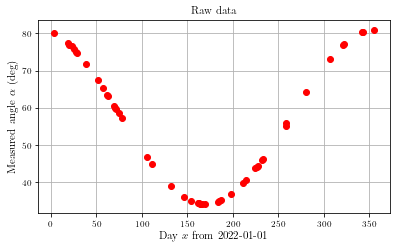

In [3]:
# DATA AND FITTED CURVE #

formatted_CSV_path = "Formatted CSV/SVM_PlotData_from_2022-01-01_to_2022-12-31.csv"
# SVM_PlotData_from_2021-01-01_to_2022-12-23.csv
CSV = pd.read_csv(formatted_CSV_path, sep=',')
CSV = CSV.dropna() #otherwise emcee gets sad

"""
    day:            days from 2021 
    measured_data:  max angle that day
    sigma:          standard deviation of measurement
    fitted_curve:   function of theta and x
"""
header = CSV.columns.values
day = np.array(CSV[header[3]])
measured_data = np.array(CSV[header[4]])
sigma = np.array(CSV[header[5]]) #the uncertainty in the measurements is +-0.25 deg # TODO: perhaps can do this better or more rigorously=

sigma = (1/np.sqrt(3)) * (sigma) # standard deviation for a uniform distribution is (1/sqrt(3)) * a, where uniform in the range [-a, +a]

# Parameter values for prior
theta_labels = ["$a$", "$b$", "$c$", "$d$"]
a_min, a_max = 0, 90 # a \in [0, 90] for latitude (from the stars I can tell that I'm on the northen hemisphere)
b_min, b_max = 0, 90 # b \in [0, 90] for the Earths axial tilt (could take 0, 180) but that would be equivalent with having the hemispheres shifted
c_min, c_max = 350, 380 # c is number of days in a year
d_min, d_max = -190, 190 # d is number of days in shift

c_mu, c_sigma = 365.25, 1.0 # c is number of days in a year
d_mu, d_sigma = 11.0, 2.0 # d is number of days in shift

day = day - np.ones_like(day) - 365
# Check that raw data looks good
plt.title("Raw data")
plt.errorbar(day, measured_data, yerr=sigma, color='r', marker='o', linestyle='')
plt.xlabel("Day $x$ from 2022-01-01") #changed to 2022
plt.ylabel("Measured angle $\\alpha$ (deg)")
plt.grid()

In [4]:
# FUNCTIONS #

def calculate_fitted_curve(theta, day):
    a, b, c, d = theta

    # a latitude (in degrees)
    # b Earth's axial tilt (in degrees)
    # c days in a year (periodicity of solar angle) (in days) 
    # d phase - difference between solar year and human year (in days)
    return a + b*np.cos(2*np.pi*(day+d)/c)

def log_prior_flat(theta, theta_max):
    any_parameter_outside_flat_prior = 0
    for i in range(len(theta)):
        if theta[i] >= theta_min[i] and theta[i] <= theta_max[i]:
            continue
        else:
            any_parameter_outside_flat_prior = 1
 
    if any_parameter_outside_flat_prior == 0:
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_prior_uniform(theta_i, theta_i_min, theta_i_max):
    if (theta_i_min <= theta_i) and (theta_i <= theta_i_max):
        return 0
    else:
        return -np.inf

def log_prior_Gaussian(theta_i, mu, sigma):
    return -np.log(sigma) - 0.5*np.log(2*np.pi) - (theta_i - mu)**2 / (2 * sigma**2)

def log_likelihood(theta, day, measured_data, sigma):

    log_likelihood = 0
    for i in range(len(day)):
        fitted_curve_value = calculate_fitted_curve(theta, day[i])
        log_likelihood += -(1/2) * (fitted_curve_value - measured_data[i])**2 / sigma[i]**2 #log of likelihood is sum of chi^2-terms 
    
    return log_likelihood

def log_posterior(theta, day, measured_data, sigma):
    log_prior_a = log_prior_uniform(theta[0], a_min, a_max)
    log_prior_b = log_prior_uniform(theta[1], b_min, b_max)
    log_prior_c = log_prior_uniform(theta[2], c_min, c_max)
    log_prior_d = log_prior_uniform(theta[3], d_min, d_max)

    #log_prior_c = log_prior_Gaussian(theta[2], c_mu, c_sigma)
    #log_prior_d = log_prior_Gaussian(theta[3], d_mu, d_sigma)

    log_prior = log_prior_a + log_prior_b + log_prior_c + log_prior_d

    return log_likelihood(theta, day, measured_data, sigma) + log_prior

def run_MCMC(starting_position_walkers, number_of_walkers, number_of_dimensions, number_of_burn_in_steps, number_of_production_steps, data, log_posterior):#, backend):
    sampler = emcee.EnsembleSampler(number_of_walkers, number_of_dimensions, log_posterior, args=data)#, backend=backend)
    print("MCMC sampling")
    print("Running: burn-in")
    pos_burn_in, prob_burn_in, state_burn_in = sampler.run_mcmc(starting_position_walkers, number_of_burn_in_steps)
    sampler.reset()

    print("Running: production")
    pos_production, prob_production, state_production = sampler.run_mcmc(pos_burn_in, number_of_production_steps)#, store=True)

    return sampler, pos_burn_in, prob_burn_in, state_burn_in, pos_production, prob_production, state_production

In [5]:
# Preparations to run MCMC #

data = [day, measured_data, sigma]
initial_theta = np.array([57.7, 23.4, 365.25, 10]) #initial parameter guess to help MCMC be faster

number_of_walkers = 10
number_of_burn_in_steps = 1000
number_of_production_steps = 100000
number_of_dimensions = len(initial_theta)
MCMC_filename = f"MCMC_walkers{number_of_walkers}_burninsteps{number_of_burn_in_steps}_productionsteps{number_of_production_steps}"
# Setup backend to save data to file
backend = emcee.backends.HDFBackend(f"MCMC data/{MCMC_filename}.h5")
backend.reset(number_of_walkers, number_of_dimensions)

# Randomize starting positions
starting_position_walkers = np.array(initial_theta) + np.random.rand(number_of_walkers, number_of_dimensions)


In [6]:
# RUN MCMC #
sampler, pos_burn_in, prob_burn_in, state_burn_in, pos_production, prob_production, state_production = run_MCMC(starting_position_walkers, number_of_walkers, number_of_dimensions, number_of_burn_in_steps, number_of_production_steps, data, log_posterior)#, backend)

MCMC sampling
Running: burn-in
Running: production


DONE: set_font_size: (axis, tick, legend): 11, 9, 9


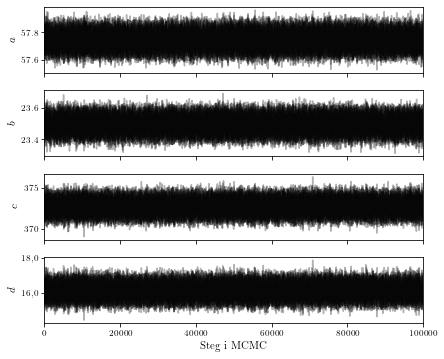

In [34]:
# PARAMETER AS FUNCTION OF STEP #

reader_filename = MCMC_filename#"MCMC_walkers40_burninsteps1000_productionsteps50000"
#reader = emcee.backends.HDFBackend(f"MCMC data/{reader_filename}.h5", read_only=True)
#samples = reader.get_chain()
samples = sampler.get_chain() # shape: (number_of_iterations, number_of_walkers, len(theta))

fig, axes = plt.subplots(number_of_dimensions, figsize=(16/2.54, 13/2.54), sharex=True)
for i in range(number_of_dimensions):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(theta_labels[i])
 
axes[-1].set_xlabel("Steg i MCMC")
for ax in fig.get_axes():
    ax.tick_params(axis='both')
set_font_size(11,9,9)


fig.tight_layout()
fig.savefig(f"MCMC figures/theta_vs_steg_nummer_{reader_filename}.pdf")
#tau = sampler.get_autocorr_time()
#print(f"Autocorrelation time (steps): {tau}")
# Styling


len(flat_samples) = 1000000


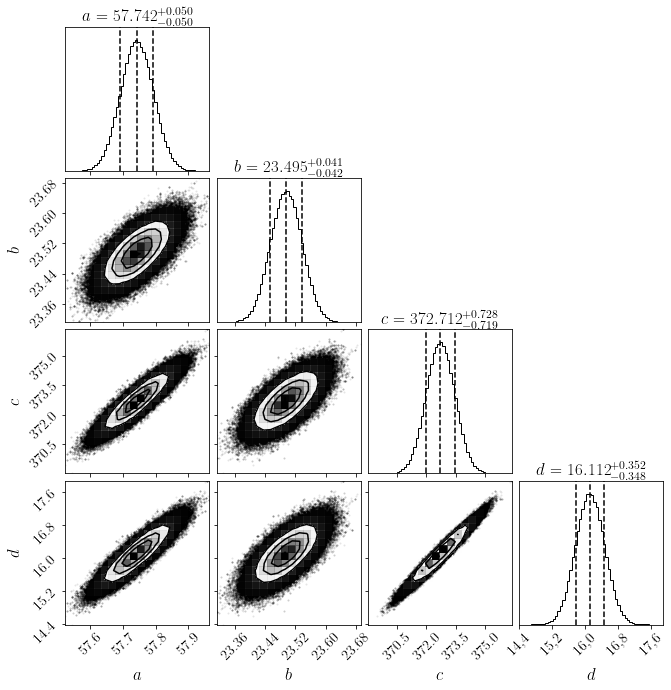

In [33]:
#flat_samples = reader.get_chain(flat=True)
flat_samples = sampler.get_chain(flat=True)
print(f"len(flat_samples) = {len(flat_samples)}")

#sampled_parameter_values = flat_samples[np.argmax(reader.flatlnprobability)]
#print(sampled_parameter_values)
#q_1, q_2, q_3 = 0.001, 0.5, 0.999#0.0455, 0.5000, 0.9545
fig = corner.corner(flat_samples,
                    plot_datapoints=True,
                    labels=theta_labels,
                    title_fmt=".3f",
                    #title_quantiles=[q_1, q_2, q_3], #cannot do this because not implemented in source code...
                    quantiles=[0.16, 0.50, 0.84],
                    show_titles=True,
                    hist_bin_factor=3,
                    title_kwargs={"fontsize": 17},
                    label_kwargs={"fontsize": 17},)
# Styling
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=14)

#fig.tight_layout()
fig.savefig(f"MCMC figures/corner_{reader_filename}.pdf")

MAP parameter value (+1sigma, -1sigma) (+2sigma, -2sigma) (+3sigma, -3sigma), (+4sigma, -4sigma), (+5sigma, -5sigma)
theta[0]: \num{57.742}$ & $\substack{+\num{0.050} \\ -\num{0.050}}$ & $\substack{+\num{0.086} \\ -\num{0.085}}$ & $\substack{+\num{0.141} \\ -\num{0.138}}$ & $\substack{+\num{0.196} \\ -\num{0.192}}$ & $\substack{+\num{0.222} \\ -\num{0.216}}$
theta[1]: \num{23.495}$ & $\substack{+\num{0.041} \\ -\num{0.042}}$ & $\substack{+\num{0.070} \\ -\num{0.070}}$ & $\substack{+\num{0.115} \\ -\num{0.115}}$ & $\substack{+\num{0.157} \\ -\num{0.161}}$ & $\substack{+\num{0.192} \\ -\num{0.183}}$
theta[2]: \num{372.712}$ & $\substack{+\num{0.728} \\ -\num{0.719}}$ & $\substack{+\num{1.235} \\ -\num{1.221}}$ & $\substack{+\num{2.036} \\ -\num{1.987}}$ & $\substack{+\num{2.785} \\ -\num{2.706}}$ & $\substack{+\num{3.638} \\ -\num{3.425}}$
theta[3]: \num{16.112}$ & $\substack{+\num{0.352} \\ -\num{0.348}}$ & $\substack{+\num{0.597} \\ -\num{0.591}}$ & $\substack{+\num{0.983} \\ -\num{0.9

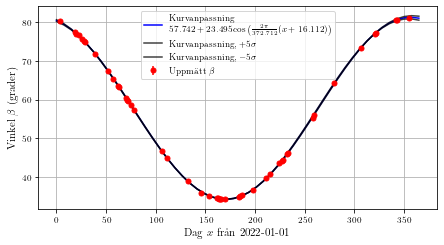

In [19]:
# GET THETA THAT MAXIMIZES POSTERIOR PROBABILITY #
theta_MAP, theta_MAP_plus_one_sigma, theta_MAP_minus_one_sigma, theta_MAP_plus_two_sigma, theta_MAP_minus_two_sigma, theta_MAP_plus_three_sigma, theta_MAP_minus_three_sigma, theta_MAP_plus_four_sigma, theta_MAP_minus_four_sigma, theta_MAP_plus_five_sigma, theta_MAP_minus_five_sigma = [], [], [], [], [], [], [], [], [], [], []

print("MAP parameter value (+1sigma, -1sigma) (+2sigma, -2sigma) (+3sigma, -3sigma), (+4sigma, -4sigma), (+5sigma, -5sigma)")
for i in range(number_of_dimensions):
    theta_MAP.append(np.percentile(flat_samples[:, i], [50]))
    theta_MAP_plus_one_sigma.append(np.percentile(flat_samples[:,i], [84]))
    theta_MAP_minus_one_sigma.append(np.percentile(flat_samples[:,i], [16]))

    theta_MAP_plus_two_sigma.append(np.percentile(flat_samples[:,i], [95.4499736]))
    theta_MAP_minus_two_sigma.append(np.percentile(flat_samples[:,i], [100-95.4499736]))

    theta_MAP_plus_three_sigma.append(np.percentile(flat_samples[:,i], [99.7300203]))
    theta_MAP_minus_three_sigma.append(np.percentile(flat_samples[:,i], [100-99.7300203]))

    theta_MAP_plus_four_sigma.append(np.percentile(flat_samples[:,i], [99.9936657]))
    theta_MAP_minus_four_sigma.append(np.percentile(flat_samples[:,i], [100-99.9936657]))

    theta_MAP_plus_five_sigma.append(np.percentile(flat_samples[:,i], [99.9999426696856]))
    theta_MAP_minus_five_sigma.append(np.percentile(flat_samples[:,i], [100-99.9999426696856]))

    string = "theta[%.0d]: \\num{%.3f}$ & $\\substack{+\\num{%.3f} \\\\ -\\num{%.3f}}$ & $\\substack{+\\num{%.3f} \\\\ -\\num{%.3f}}$ & $\\substack{+\\num{%.3f} \\\\ -\\num{%.3f}}$ & $\\substack{+\\num{%.3f} \\\\ -\\num{%.3f}}$ & $\\substack{+\\num{%.3f} \\\\ -\\num{%.3f}}$" % (i, theta_MAP[i], theta_MAP_plus_one_sigma[i]-theta_MAP[i], theta_MAP[i]-theta_MAP_minus_one_sigma[i], theta_MAP_plus_two_sigma[i]-theta_MAP[i], theta_MAP[i]-theta_MAP_minus_two_sigma[i], theta_MAP_plus_three_sigma[i]-theta_MAP[i], theta_MAP[i]-theta_MAP_minus_three_sigma[i], theta_MAP_plus_four_sigma[i]-theta_MAP[i], theta_MAP[i]-theta_MAP_minus_four_sigma[i], theta_MAP_plus_five_sigma[i]-theta_MAP[i], theta_MAP[i]-theta_MAP_minus_five_sigma[i])
    print(string)




#theta_MAP = [57.753, 23.495, 372.715, 22.830]
days_linspace = np.linspace(0, 365)
fitted_curve_theta_MAP = calculate_fitted_curve(theta_MAP, days_linspace)
fitted_curve_theta_MAP_plus_one_sigma  = calculate_fitted_curve(theta_MAP_plus_one_sigma, days_linspace)
fitted_curve_theta_MAP_minus_one_sigma = calculate_fitted_curve(theta_MAP_minus_one_sigma, days_linspace)
fitted_curve_theta_MAP_plus_five_sigma  = calculate_fitted_curve(theta_MAP_plus_five_sigma, days_linspace)
fitted_curve_theta_MAP_minus_five_sigma = calculate_fitted_curve(theta_MAP_minus_five_sigma, days_linspace)

fitted_curve_label = "Kurvanpassning\n$%.3f + %.3f\\cos\\left(\\frac{2\\pi}{%.3f}(x+%.3f)\\right)$" % (theta_MAP[0], theta_MAP[1], theta_MAP[2], theta_MAP[3])

#plt.title("Measured data compared to Bayesian analysis")
#plt.rcParams['figure.figsize'] = (20/2.54, 11/2.54)
plt.errorbar(day, measured_data, yerr=sigma, color='r', marker='o', markersize=5, linestyle='', label='Uppmätt $\\beta$')
plt.plot(days_linspace, fitted_curve_theta_MAP, color='b', label=fitted_curve_label)
plt.plot(days_linspace, fitted_curve_theta_MAP_plus_five_sigma, color='k', alpha=0.75, label='Kurvanpassning, $+5\\sigma$')
plt.plot(days_linspace, fitted_curve_theta_MAP_minus_five_sigma, color='k', alpha=0.75, label='Kurvanpassning, $-5\\sigma$')
plt.xlabel("Dag $x$ från 2022-01-01")
plt.ylabel("Vinkel $\\beta$ (grader)")
plt.legend()
plt.grid()
set_font_size(11,9,9)
#plt.xlim(480, 600)
#plt.ylim(30, 50)
plt.tight_layout()
plt.savefig(f"MCMC figures/Measured_compared_bayesian_analysis_5sigma.pdf")

57.742664995498245 [57.74244898]
DONE: set_font_size: (axis, tick, legend): 11, 9, 9


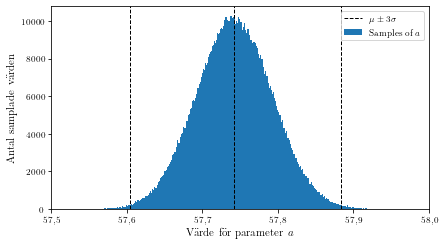

In [30]:
# Histogram of samples from MCMC #
fig, ax = plt.subplots()
a_samples = flat_samples[:,0]
b_samples = flat_samples[:,1]
print(np.mean(a_samples), theta_MAP[0])
plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
y_max = np.max(a_samples)
#plt.title("Histogram of samples from MCMC")
plt.hist(a_samples, 343, label="Samples of $a$")
vlines = [np.mean(a_samples), theta_MAP_plus_three_sigma[0], theta_MAP_minus_three_sigma[0]]
for i in range(len(vlines)):
    if i == 0:
        plt.axvline(vlines[i], color='k', linestyle='dashed', linewidth=1, label=f"$\\mu \\pm 3 \\sigma$")
    else:
        plt.axvline(vlines[i], color='k', linestyle='dashed', linewidth=1)
#plt.hist(b_samples, 151, label="Samples of $b$")
plt.xlabel("Värde för parameter $a$")
plt.ylabel("Antal samplade värden")
plt.xlim(57.5, 58.0)
plt.legend()
#ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:#.2n}'))
set_font_size(11,9,9)
#plt.grid()
xFormatString = '{:.1f}'
ax.get_xaxis().set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, pos: xFormatString.format(x).replace('.', ',')) ) 
plt.tight_layout()
plt.savefig(f"MCMC figures/Histogram_a_samples_MCMC_100000productionsteps_svenska.pdf")
plt.show()